In [5]:
#Import cluster algorithms
from sklearn.cluster import KMeans, DBSCAN

#Import classifiers
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

#Import libraries to deal with data
import numpy as np
import pandas as pd
import pickle


#Process data libraries
from skimage import io
from scipy import signal
import pylab, wave
from scipy.io import wavfile

#Miscelanous
import math
import time
import os
import warnings


#Graphs and show images
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches



np.random.seed(10)
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
%matplotlib inline 


In [17]:
##############################################
#                                            #
#                Spectrogram                 #
#                                            #
##############################################
#Function to retrieve data from wav files
def wavInfo(rec_file):
    sample_rate, samples = wavfile.read(rec_file)
    channels  = wave.open(rec_file, 'r').getnchannels()
    return sample_rate, samples, channels


#Function to calcualte spectrogram
def specInfo(rec_file):
    sampleRate, samples, channels = wavInfo(rec_file)
    
    #Solution for one channels
    if(channels == 1):
        freqs, t, spectrum  = signal.spectrogram(samples[:], nfft=512, window="hann", fs=sampleRate)
        
    #Solution for two channels
    elif(channels == 2):
        freqs, t, spetctrum = signal.spectrogram(samples[:, 1], nfft=512, window="hann", fs=sampleRate)
        
        spectrum = spectrum.astype("float64") 
    return t,freqs,spectrum

##############################################
#                                            #
#              Image/Plotting                #
#                                            #
##############################################
def plotModSpecSimple(times, freqs, specMod, figsize = (8,4), xlab = "", ylab = "", title = "", colorbar = True, patch = None, cmap = "Purples"):
    """ 
        Function to plotspectrograms and bounding boxes in spectrograms
        Input:
            times - np array containing time steps (shape X,1)
            freqs - np array containing frequency steps (shape Y,1)
            specMod - np array containing magnitude values on each time step for each frequency (shape - (Y,X))
            figsize - list containing width and height size for the figure
            xlab - string containining label for x axis
            ylab - string contaiing label for y axis
            title - string containing title for the graph
            colorbar - bool value to decide whether graph should contain colorbar graph or not
            patch - array containing matplotlib.patches to be applied to the plot
            cmap - cmap for color displaying
    """
    print(f"Times shape: {times.shape}")
    print(f"Freqs shape: {freqs.shape}")
    print(f"Spectrum shape: {specMod.shape}")
    
    fig, ax = pylab.subplots(1,1, figsize = figsize)
    ax.set_facecolor("grey")
    im = ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Plot spectrogram information given
    ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Add all patches to figure, if any
    if (patch !=None ):
        for i in patch:
            ax.add_patch(i)
    
    #Set x axis label
    ax.set_xlabel(xlab)
    
    #Set y axis label
    ax.set_ylabel(ylab)
    
    #Set title label
    ax.set_title(title)
    
    #Set colorbar if wanted
    if(colorbar):
        fig.colorbar(im, ax=ax)
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# def visualizeTraining(data, num):
    
#     for i in range(num):
#         startPT = time.time()
#         file = data['archivo'][i]
#         minf = data['freqme'][i]
#         maxf = data['freqma'][i]
#         startT = data['tiempoi'][i]
#         endT = data['tiempof'][i]
#         t, freq,spec, t2,freq2,spec2 = getMarca(file, minf,maxf, startT,endT)
        
#         #Cluster noise
#         clusters = 4
#         kCluster = KMeans(clusters)
#         flatSpectrum = spec2.flatten().reshape(-1,1)
#         res = kCluster.fit_predict(flatSpectrum)
#         res = orderClusters(res, flatSpectrum, clusters)
        
    
#         #Set all values other than 0 to 1 
#         correctingIdx = np.where(res != 0)[0]
#         res = np.zeros(flatSpectrum.shape)
#         res[correctingIdx] = 1
#         res = res.reshape(spec2.shape)
        
#         trainMatrix = np.zeros((freq.shape[0], 1000))
#         for i in range(res.shape[0]):
#             trainMatrix[i][:res.shape[1]]= res[i]

#         endPT = time.time()
#         print(endPT - startPT, data['especie_id'][i])
# #         disk = morphology.disk(1)
# #         plotModSpecSimple(t,freq,morphology.erosion((trainMatrix), disk))
# #         disk = morphology.disk(1.4)
        
# #         plotModSpecSimple(t,freq,morphology.dilation((trainMatrix), disk))
#         plotModSpecSimple(t,freq,trainMatrix)
    

##############################################
#                                            #
#              Data processing               #
#                                            #
##############################################



def Filter(array, Min, Max):
    '''Given a Min or Max parameter, find the index in the array that corresponds to the given Min or Max value
    #Example  [1,4,7,11], Min:5, Max 8, Output = (1,3)
    Input: 
        array: nparray containing information
        min  : float containing the minimum value to be found in array
        max  : float containing the maximum value to be found in array
    '''
    try:
        Min = (np.abs(array-Min)).argmin()
        Max = (np.abs(array-Max)).argmin()+1
    
        return Min, Max
    
    except:
        print("error: array input is not an nparray")
        
        
# def getMarca(path = "", file, minf, maxf, startT, endT, timeSize = 1000, freqSize = 100):
#     ''' 
#     '''
#     path = "Audio/Experimental/dataset/trainMarcas/"
#     t,freq,spec = specInfo(path + file)
    
#     #Find index of the time in the array 
#     startI = (np.abs(t - startT)).argmin()
#     endI = (np.abs(t - endT)).argmin()
    
#     #Find index of the frequencies in the array
#     mifreqI = (np.abs(freq - minf)).argmin()
#     mafreqI = (np.abs(freq - maxf)).argmin()
    
#     t2 = t[startI:endI]
#     freq2 = freq[mifreqI:mafreqI]
    
#     mags = [spec[mifreqI][startI:endI]]
    
#     for i in range(mifreqI+1, mafreqI):
#         mags = mags + [spec[i][startI:endI]]  
#     spec2 = np.array(mags)
#     return t[0:timeSize], freq[0:freqSize], spec, t2, freq2, spec2


def getMarcaFromSpectrogram(t, freq, spec, minf, maxf, startT, endT, timeIndex):
    
    #Find index of the time in the array 
    startI, endI= Filter(t, startT, endT)
    
    #ind index of the frequencies in the array    
    minfreqI, maxfreqI = Filter(freq, minf, maxf)
    
    
    tSelect = t[startI:endI]
    freqSelect = freq[minfreqI:maxfreqI]
    
    print(str(endI))
    print(str(startI))

    if endI - startI > timeIndex:
        print("entre al if")
        endI = startI+timeIndex
        
    mags = [spec[minfreqI][startI:endI]]
        
    for i in range(minfreqI+1, maxfreqI):
        mags = mags + [spec[i][startI:endI]]  
    specSelect = np.array(mags)
    
    return tSelect, freqSelect, specSelect, minfreqI, maxfreqI



def newSlicing(array, lowerIdx, upperIdx, step):
    resultingArray = np.array(array[lowerIdx:upperIdx])
    for i in range(upperIdx,len(array)+1,step):
        lowerIdx += step
        upperIdx+= step
        resultingArray = np.concatenate([resultingArray, array[lowerIdx:upperIdx]])

    return resultingArray

def orderClusters(flatCluster, flatSpectrogram, num, getGroups = False ):
    """Function to order the clusters according to the magnitude values
       Returns a vector containing the indeces of each cluster, where the 
       indeces identify which cluster is stronger in terms of magnitude(relative to spectrum)
    
       Input:
           flatCluster: Array containing flattened spectrogram's shape with cluster entries
           flatSpectrogram
    """
    
    minS = [None]*num
    maxS = [None]*num
    smallVal = np.array([])
    
    #
    for i in range(num):
        #identify each cluster
        idx = np.where(flatCluster ==i )
        
        #Find min and max values of each cluster
        minS[i] = min(flatSpectrogram[idx])
        maxS[i] = max(flatSpectrogram[idx])
        
        #Store the min value, so we can order the clusters according to the corresponding value
        smallVal = np.append(smallVal, minS[i])
        
    #Create buffer that will contain the cluster identifier information
    returnCluster = np.zeros(flatCluster.shape)
    
    #Fill the buffer containing the cluster identifier in ordered shape (min to max)
    for ctr, i in enumerate(np.argsort(smallVal)):
        idx = np.where(flatCluster == i)
        returnCluster[idx] = ctr
        

    del minS, smallVal, idx
    if getGroups:
        return returnCluster,maxS
    return returnCluster


#MISC

class Error(Exception):
    """Base class for exceptions in this module."""
    
    pass

[[   0.8922006     5.097459      1.2463439  ...  425.45312
  1324.3777     1760.493     ]
 [   1.0885376    28.473589     10.623506   ... 1437.7534
  3423.5784     4362.442     ]
 [   5.0662155    60.26107      12.514093   ... 2505.457
  4300.931      5223.0127    ]
 ...
 [   0.00000149    0.00001835    0.00000916 ...    0.00000273
     0.00001221    0.0000263 ]
 [   0.00000513    0.00001646    0.00002009 ...    0.00000098
     0.00000257    0.00003892]
 [   0.00000522    0.00000684    0.00001422 ...    0.00000007
     0.00000003    0.00001841]]
(257, 12740)
Times shape: (12740,)
Freqs shape: (257,)
Spectrum shape: (257, 12740)


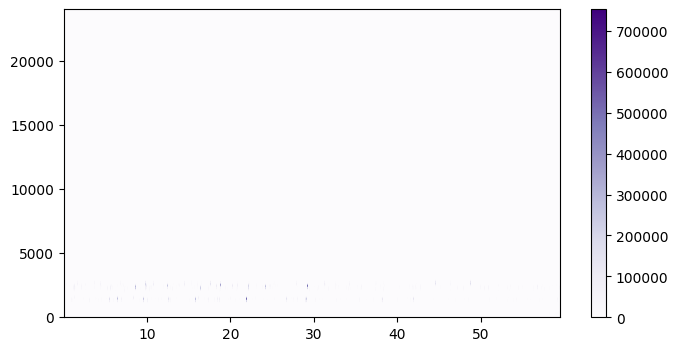

In [18]:
#audio file path
path = "03-10-3022_30_38.wav"

#Get spectrogram data
calculateSpecT = time.time()
t,freq,spec = specInfo(path)
print(spec)
print(spec.shape)
# print(freq)
# print(t)
# print(len(t))
# print("Spectrogram calculation time:", time.time()- calculateSpecT, "seconds")#outputs spectrogram calculation time
#Plot spectrogram dataspecInfo
plotModSpecSimple(t,freq,spec)

In [8]:
dataDescription = pd.read_csv("marcasArticulo.csv") 
dataDescription.head()

FileNotFoundError: [Errno 2] No such file or directory: 'marcasArticulo.csv'

In [ ]:
MarkIndex = 0
file = dataDescription['archivo'][MarkIndex]
minimumFrequency = dataDescription['freqme'][MarkIndex]
maximumFreqeuency = dataDescription['freqma'][MarkIndex]
startTime = dataDescription['tiempoi'][MarkIndex]
endTime = dataDescription['tiempof'][MarkIndex]
print(file)
print(minimumFrequency)
print(maximumFreqeuency)
print(startTime)
print(endTime)

#Set a default value for Duration of mark 
# revisar
durationTime = 460

03-10-3104_00_35.wav
1266.1
2770.6
2.8089999999999997
3.1919999999999997


In [6]:
    #Get spectrogram information of mark
    tSelect, freqSelect, specSelect, minFreq, maxFreq = getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, durationTime)

    #Plot the mark
    plotModSpecSimple(tSelect, freqSelect, specSelect, ylab = "Frequency (Hz)", xlab = "Time (s)")

NameError: name 'minimumFrequency' is not defined

In [ ]:
#Define clusters and kmeans cluster instace
clusters = 6
kCluster = KMeans(clusters)

#First we must flatten the data to cluster it (1 dimensional vector)
specSelectFlatten = specSelect.flatten().reshape(-1,1)

Y axis in this plot is a density proportion of the count for each bin in magnitude values


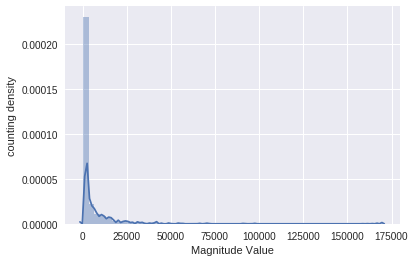

In [ ]:
#Plot a histogram of magnitude values
ax = sns.distplot(specSelectFlatten, hist = True, norm_hist=False, axlabel= "Magnitude Value")
ax.set_ylabel("counting density")
print("Y axis in this plot is a density proportion of the count for each bin in magnitude values")

In [ ]:

#Cluster the magnitude values
#The returning vector will contain the cluster group associated to each entry 
specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)

In [ ]:
#Make sure we order labels based on cluster's magnitude
specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, clusters,  True)

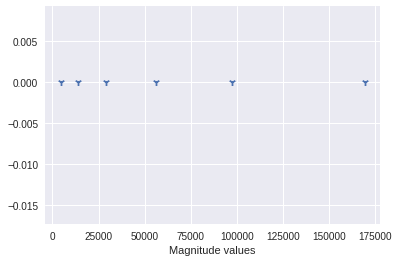

In [ ]:
#Representation of clusters, between each marker is a cluster group
plt.scatter(np.concatenate(clusterMax), [[0]*clusters], marker = "1")
plt.xlabel("Magnitude values")


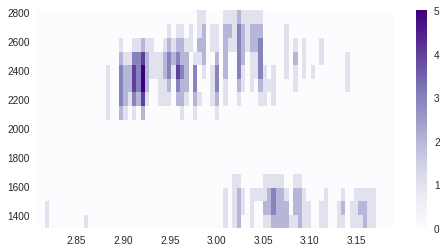

In [ ]:
#Display how mark looks like after clutering magnitude values
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape))

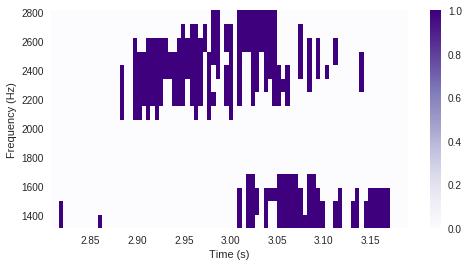

In [ ]:
#Prepare data
#Set all values other than 0 to 1 
correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
copySelectFlattenCluster = specSelectFlattenCluster
specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

#Set all values not equal to 0 to 1. 
specSelectFlattenCluster[correctingIdx] = 1
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

In [ ]:
#Get coordinates of relevant points (Coordinates of those values containing 1)
yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
coordinatesArray = np.array([yIndeces, xIndeces]).T


In [ ]:
#Define DBScan instace
DBScan = DBSCAN(2,8)

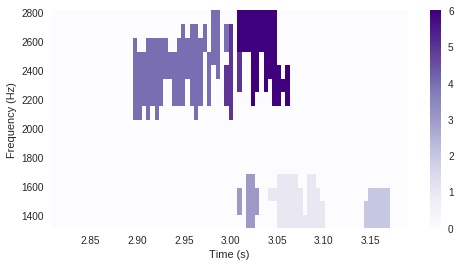

In [ ]:
detectedGroups = DBScan.fit_predict(coordinatesArray)

#Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
minIndex = np.min(detectedGroups)


#In order to have a range from 0 to 1, add abs value of minIndex ( if min index = 0 , it will remain the same
#if minIndex == -1, it will relocate range from 0 to maxIndex+1)
copySelectFlattenCluster[correctingIdx] = detectedGroups + abs(minIndex)
detectedGroups += abs(minIndex)
plotModSpecSimple(tSelect,freqSelect,copySelectFlattenCluster.reshape(specSelect.shape), xlab = "Time (s)", ylab = "Frequency (Hz)")

displayGroups = np.zeros(specSelect.shape)

for ctr, i in enumerate(coordinatesArray):
    displayGroups[int(i[0])][ int(i[1])] = detectedGroups[ctr]
maxIndex = np.max(detectedGroups)

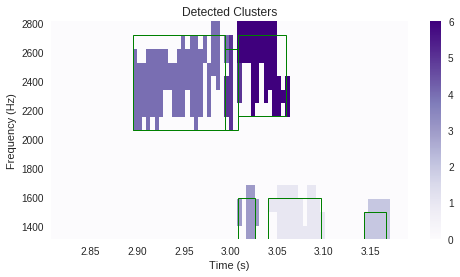

In [ ]:
rect = []
for speechValue in range(1, maxIndex+1):
    if len(np.where(detectedGroups== speechValue)[0]) != 0 :
        
        #Get min and max time and frequency values of the identified cluster groups
        minf = np.min(np.where(displayGroups == speechValue)[0])
        maxf = np.max(np.where(displayGroups == speechValue)[0])
        startT = np.min(np.where(displayGroups == speechValue)[1])
        endT = np.max(np.where(displayGroups == speechValue)[1])

        #Create bounding box and add to boxes to be displayed
        rect.append(patches.Rectangle((tSelect[startT],freqSelect[minf]),tSelect[endT]-tSelect[startT],freqSelect[maxf]-freqSelect[minf],linewidth=1,edgecolor='g',facecolor='none'))

#Display marc with bounding boxes around the cluster groups found
plotModSpecSimple(tSelect,freqSelect,displayGroups, xlab = "Time (s)", ylab = "Frequency (Hz)", title = "Detected Clusters", patch = rect)


267
267
267
267
267
267


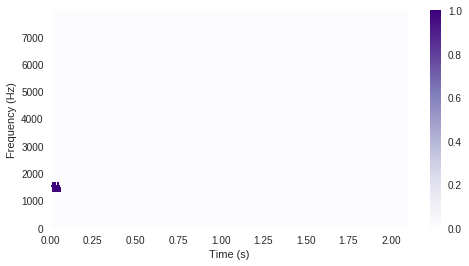

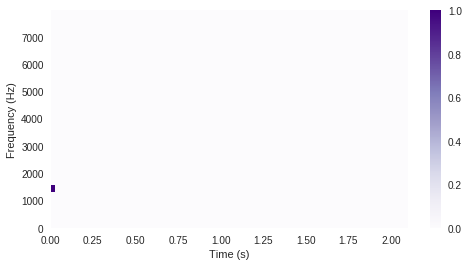

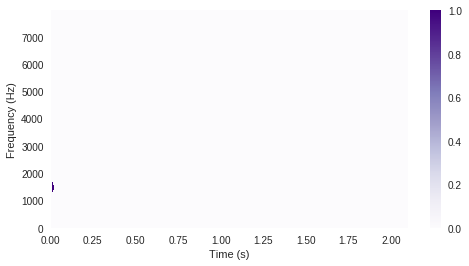

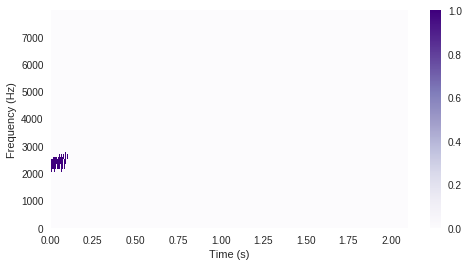

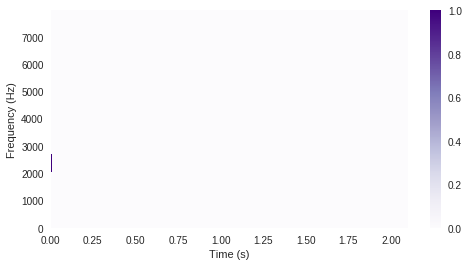

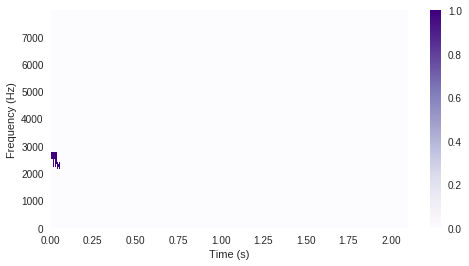

In [ ]:
#Define training model parameters
#These two parameters are used to define how many time steps and frequencies will the training model have
timeInterval = 450
frequencyInterval = 86


for speechValue in range(1, maxIndex+1):
    speechIndexes = np.where(detectedGroups == speechValue)[0]

    minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

    trainMatrix = np.zeros((frequencyInterval ,timeInterval))
    print(len(coordinatesArray))
    for ctr, i in enumerate(coordinatesArray[speechIndexes]):
        if i[1] - minVal < timeInterval:
            trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
    
    plotModSpecSimple(t[0:timeInterval], freq[0:frequencyInterval],trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")    

In [ ]:
trainMatrix.shape

(86, 450)

In [ ]:
def transformDataset2( dataset, timeIndex, freqIndex, especieCounter,  frequencyInterval =86, dbscanE = 2, dbscanMin = 8, kmeanCluster = 6, datasetPath = "../dataset2/audios/"):
    DBScan = DBSCAN(dbscanE,dbscanMin)
    markLoad = []
    markLabel = []
    markFailed = []
    kCluster = KMeans(kmeanCluster)
    trainMatrix = np.zeros((freqIndex, timeIndex), dtype = "int8")
    
#     cambiar aqui    
    groupByFile = dataset.groupby("archivo")

    fctr = 0
    for eachFile in groupByFile:

        #Each file contains all the metadata ifilenformation for each file
            
        #Get file name from each file
        fileName = eachFile[0]
        
        t,freq, spec = specInfo(datasetPath + fileName)
        print(t)

        for idx, data in eachFile[1].iterrows():
            try:

                minimumFrequency = data['freqme']
                maximumFreqeuency = data['freqma']
                startTime = data['tiempoi']
                endTime = data['tiempof']

                tSelect, freqSelect, specSelect, minFreq, maxFreq= getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, timeIndex)
    #                 return 0 

                #Cluster noise
                specSelectFlatten = specSelect.flatten().reshape(-1,1)

                specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)
                specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, kmeanCluster,  True)


                correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
                copySelectFlattenCluster = specSelectFlattenCluster
                specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

                #Set all values not equal to 0 to 1. 
                specSelectFlattenCluster[correctingIdx] = 1
                #plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

                #Get coordinates of relevant points (Coordinates of those values containing 1)
                yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
                coordinatesArray = np.array([yIndeces, xIndeces]).T

                detectedGroups = DBScan.fit_predict(coordinatesArray)

                #Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
                minIndex = np.min(detectedGroups)
                detectedGroups += abs(minIndex)
                maxIndex = np.max(detectedGroups)

                trainMatrix = np.zeros((frequencyInterval ,timeIndex), dtype = "int8")

                for speechValue in range(1, maxIndex+1):
                    speechIndexes = np.where(detectedGroups == speechValue)[0]

                    minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

                    trainMatrix[:,:] = 0

                    for ctr, i in enumerate(coordinatesArray[speechIndexes]):
                        if i[1] - minVal < timeIndex:
                            trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
                #plotModSpecSimple(t[0:timeInterval], freq[0:frequencyInterval],trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")    

                    especieCounter[data['especie_id']]+=1
                    markLoad.append(trainMatrix)
                    markLabel.append(data['especie_id'])
            except Exception as e:
                markFailed.append(idx)
                print("Marked failed: ", idx)
                print(e, "\n\n")
    markLabel = np.array(markLabel)
    markLoad = np.array(markLoad)
    
    #/order by species id
    idx = np.argsort(markLabel)
    markLoad[:] = markLoad[idx]
    markLabel[:] = markLabel[idx]

    return markLoad, markLabel, especieCounter

In [ ]:
maxFreqForInterval = 8000

dataDescription = pd.read_csv("marcasArticulo.csv") 
speciesID = dataDescription['especie_id'].unique()[:-1]#gives array of all species in csv

    #Since we are only using the 8000 frequencies and below, remove species outside the bounds ##why are we only using freqs < 8000
dataDescription = dataDescription.groupby('especie_id').filter(lambda x: max(x['freqma']) < 8000)


indexes= dataDescription.index[dataDescription['especie_id'] == 12]
dataDescription = dataDescription.drop(indexes).reset_index()
print(dataDescription)
indexes= dataDescription.index[dataDescription['especie_id'] == 10]
dataDescription = dataDescription.drop(indexes).reset_index()
np.sort(dataDescription['especie_id'].unique())
print(dataDescription.shape)

maxtimeWithSTD = np.max(dataDescription.groupby('especie_id').apply(lambda x: (np.mean(x['tiempof']- x["tiempoi"]) +np.std(x['tiempof']- x["tiempoi"]))))
t,freq,spec = specInfo("../dataset2/audios/03-10-3018_00_35.wav")
# getTimeInterval = Filter(t, 0,maxtimeWithSTD)[1]
frequencyLimit = ((np.abs(freq - maxFreqForInterval)).argmin()+1)
timeLimit = ((np.abs(t - maxtimeWithSTD)).argmin()+1)


       index  marca_id  grabacion_id               archivo  punto_id  \
0          0   31978.0          25.0  03-10-3104_00_35.wav       4.0   
1          1   31968.0          25.0  03-10-3104_00_35.wav       4.0   
2          2   31979.0          25.0  03-10-3104_00_35.wav       4.0   
3          3      85.0          25.0  03-10-3104_00_35.wav       4.0   
4          4      86.0          25.0  03-10-3104_00_35.wav       4.0   
5          5      87.0          25.0  03-10-3104_00_35.wav       4.0   
6          6   31982.0          25.0  03-10-3104_00_35.wav       4.0   
7          7    6078.0          25.0  03-10-3104_00_35.wav       4.0   
8          8      88.0          26.0  03-10-3104_30_35.wav       4.0   
9          9      89.0          26.0  03-10-3104_30_35.wav       4.0   
10        10      90.0          26.0  03-10-3104_30_35.wav       4.0   
11        11      96.0          30.0  03-10-3106_30_34.wav       4.0   
12        12      97.0          30.0  03-10-3106_30_34.wav      

In [ ]:
especieGroup = dataDescription.groupby('especie_id')

#Get especies ids and the size of "marcas" and get an index array to sort the order of species in terms
#of how many marcs they have
uniqueIDs = []
counter = []
for k,v in especieGroup.groups.items():
    uniqueIDs.append(k)
    counter.append(len(v))
idx = np.argsort(counter)
#Order the array based on "marcas" amount
uniqueIDs[:] = np.array(uniqueIDs)[idx]


especieConArchivo = dataDescription.groupby(['especie_id','archivo'])


#Contiene el nombre de todas las grabaciones usadas
grabaciones = []

#Grabaciones usadas en el training
aceptadas = []

#Diccionario que contiene el nombre de las grabaciones usadas de cada especie
grabacionName = {}
#Diccionario que contiene el counter de marcas por grabacion de cada especie
counterGrab = {}
#Diccionario para contar la cantidad de marcas que tenemos de cada especie
counterEspecie ={}
for k, v in (especieConArchivo.groups).items():
    #
    if k[0] not in grabacionName.keys():
        grabacionName[k[0]] = []
        counterGrab[k[0]] = []
        counterEspecie[k[0]] = 0 
    grabacionName[k[0]].append( k[1])
    counterGrab[k[0]].append(int(len(v)))
    if k[1] not in grabaciones:
        grabaciones.append(k[1])
    
#Ordenar las grabaciones dentro de cada especie por la cantidad de marcas que contienen
for k, v in counterGrab.items():
    sortByIndex = np.argsort(counterGrab[k])[::-1]
    #Convertir arreglos a np arrays para poder ordenarlos usando indexing (argsort)
    grabacionName[k] = np.array(grabacionName[k])
    counterGrab[k] = np.array(counterGrab[k])

    grabacionName[k][:] = grabacionName[k][sortByIndex]
    counterGrab[k][:] = counterGrab[k][sortByIndex]
    

#Buffer que contiene el minimo cantidad de marcas que queremos para training
finalCounter = 200
#El for loop irá de la especie con menos marcas a la que mas tiene 
for specie in uniqueIDs:
    #Ir por cada grabacion que tiene especie
    for ctr, grabacion in enumerate(grabacionName[specie]):

        #Verificar que la cantidad de marcas para training es mayor que "finalcounter"
        if counterEspecie[specie] < finalCounter:
            #Buscar la grabacion y la cantidad de marcas obtenidas de cada especie y añadirselo al counter
            for k,v in grabacionName.items():
                idx = np.where(v  == grabacion)[0]
                if len(idx) == 1 and grabacion in grabaciones:
                    counterEspecie[k] += counterGrab[k][idx]

            #Remover la grabacion usada
            if grabacion in grabaciones:
                grabaciones.remove(grabacion)
                aceptadas.append(grabacion)
        else:
            break
# print(counterEspecie)
# print(len(grabaciones))
# print(len(aceptadas))

#Elimina grabaciones usadas en training
marcasTesting = dataDescription
for i in aceptadas:
    if i in marcasTesting['archivo'].unique():
        idx = (marcasTesting.index[marcasTesting['archivo'] == i])
        marcasTesting = marcasTesting.drop(idx)
# print(len(marcasTesting['archivo'].unique()))

#Eliminar grabaciones no usadas en training
marcasTraining =  dataDescription
for i in grabaciones:
    if i in marcasTraining['archivo'].unique():
        idx = (marcasTraining.index[marcasTraining['archivo'] == i])
#         print(idx)
#         print(idx)
        marcasTraining = marcasTraining.drop(idx)
#         print(marcasTraining.shape)
# print(len(marcasTraining['archivo'].unique()))

#Identificar la cantidad minima de marcas que unmarcasTraininga especie tiene
minMarcas = min(marcasTraining.groupby("especie_id").size())
# print(marcasTraining.groupby("especie_id").size())
trainingMarcas = minMarcas
trainingFinal = marcasTraining.groupby('especie_id').apply(lambda x: x.sample( trainingMarcas, random_state= 10))
trainingFinal.groupby("especie_id").size()
# print(trainingFinal)
# print(trainingFinal.shape)

#Identificar training set (para evaluar los modelos)
minMarcas = min(marcasTesting.groupby("especie_id").size())
# print(marcasTesting.groupby("especie_id").size(), minMarcas)
testingMarcas = minMarcas
testingFinal = marcasTesting.groupby('especie_id').apply(lambda x: x.sample( testingMarcas, random_state= 10))
# testingFinal.groupby("especie_id").size()

print("amount of especies: ", counterEspecie )

amount of especies:  {1.0: array([892]), 2.0: array([233]), 4.0: array([207]), 6.0: array([203]), 7.0: array([205]), 8.0: array([202]), 130.0: array([201])}


In [ ]:
for k,v in counterEspecie.items():
    v[0] = 0
first = time.time()
trainingDataset, trainingLabels, marcasEspecies = transformDataset2(trainingFinal, timeLimit,frequencyLimit, counterEspecie)
print("Time taken ", time.time()-first)

[ 0.00266667  0.00733333  0.012      ... 59.302      59.30666667
 59.31133333]
7556
7477
6442
6414
4165
4134
3561
3536
7263
7239
6442
6414
3561
3536
7263
7239
4165
4134
8062
8006
4723
4658
8062
8006
4723
4658
[ 0.00266667  0.00733333  0.012      ... 59.47466667 59.47933333
 59.484     ]
1466
1372
9200
9016
9200
9016
4905
4598
2641
2433
4905
4598
2371
2202
2641
2433
2174
1867
3153
2734
3680
3277
2371
2202
3680
3277
2174
1867
3153
2734
[ 0.00266667  0.00733333  0.012      ... 61.01       61.01466667
 61.01933333]
9624
9506
6456
6345
5968
5876
7224
7095
5968
5876
6456
6345
7224
7094
7224
7095
[ 0.00266667  0.00733333  0.012      ... 59.344      59.34866667
 59.35333333]
4803
4619
3788
3709
7971
7898
3892
3709
4692
4619
7971
7609
7971
7898
6980
6653
1917
1668
6431
6088
6980
6653
1917
1668
6431
6088
[ 0.00266667  0.00733333  0.012      ... 59.37666667 59.38133333
 59.386     ]
1802
1692
11164
11135
12374
12341
11164
11135
12374
12341
11164
11135
12374
12341
11164
11135
12374
12341
[ 0.00266

4957
4889
10423
10275
10423
10275
9213
8763
8536
8083
4364
4038
4364
4038
7805
7485
9672
9440
4837
4502
9213
8763
4364
4038
7805
7485
4837
4502
9672
9440
4837
4502
4837
4502
8536
8083
9213
8763
9213
8763
8536
8083
7805
7485
7805
7485
9672
9440
8536
8083
4364
4038
9672
9440
[ 0.00266667  0.00733333  0.012      ... 59.37666667 59.38133333
 59.386     ]
5071
4967
5117
4943
2891
2778
1879
1666
6924
6845
853
770
6924
6845
853
770
3985
3791
4533
4335
5148
4974
4533
4335
3985
3791
5148
4974
[ 0.00266667  0.00733333  0.012      ... 59.36733333 59.372
 59.37666667]
6916
6769
8224
8154
7740
7671
8224
8154
7740
7671
3737
3330
1678
1353
3111
2648
3737
3330
2417
1967
2417
1967
3111
2648
1678
1353
[ 0.00266667  0.00733333  0.012      ... 60.94466667 60.94933333
 60.954     ]
9964
9850
465
362
9964
9850
7063
6239
entre al if
5234
4600
entre al if
5234
4600
entre al if
994
370
entre al if
994
370
entre al if
7063
6239
entre al if
7063
6239
entre al if
5234
4600
entre al if
994
370
entre al if
[ 0.0026

2005
1915
1582
1515
11506
11340
10191
10028
10191
10028
11506
11340
[ 0.00266667  0.00733333  0.012      ... 60.93533333 60.94
 60.94466667]
4543
4429
4552
4429
2642
2491
9526
9359
9525
9359
5373
5209
5373
5209
2643
2492
[ 0.00266667  0.00733333  0.012      ... 59.36733333 59.372
 59.37666667]
9438
9339
7859
7757
3261
3197
919
858
919
858
3261
3197
2724
2666
2724
2666
7984
7830
7984
7830
4885
4721
4885
4721
4058
3885
4058
3885
1183
1147
6668
6628
6668
6628
3426
3394
1183
1147
3426
3394
[ 0.00266667  0.00733333  0.012      ... 59.37666667 59.38133333
 59.386     ]
12250
12156
8258
8210
6764
6716
8258
8210
6764
6716
[ 0.00266667  0.00733333  0.012      ... 59.316      59.32066667
 59.32533333]
5360
5269
5362
5265
6403
6312
7625
7593
1400
1198
8505
8482
8505
8482
7625
7593
1400
1198
[ 0.00266667  0.00733333  0.012      ... 59.316      59.32066667
 59.32533333]
3462
3351
10638
10599
3546
3504
7309
7270
1472
1236
6782
6732
[ 0.00266667  0.00733333  0.012      ... 59.36733333 59.372
 59.3766

1183
1112
5407
5330
558
495
5407
5330
1183
1112
5378
5287
2078
1987
2078
1987
4798
4679
4798
4679
2078
1987
5378
5287
5378
5287
4798
4679
Time taken  150.23854422569275


In [ ]:
print(testingFinal.shape)
print(trainingFinal.shape)
print("these are my marcas: ",marcasEspecies) 
key = list(marcasEspecies)
key = key[0]
print(key)
print(marcasEspecies[key])


(448, 12)
(1407, 12)
these are my marcas:  {1.0: array([834]), 2.0: array([476]), 4.0: array([704]), 6.0: array([806]), 7.0: array([779]), 8.0: array([1344]), 130.0: array([2753])}
1.0
[834]


In [ ]:
from sklearn import model_selection as mod_selec
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(trainingDataset.shape)
print(trainingLabels.shape)
print(trainingLabels[0])

(7696, 86, 469)
(7696,)
1.0


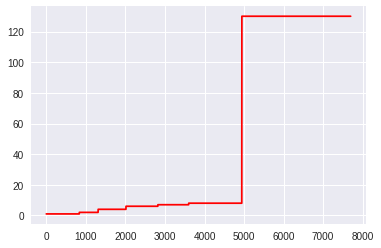

In [ ]:
plt.plot(trainingLabels, color="red")

In [ ]:
# Defining container to store score per-fold
acc_per_fold = []
print(np.unique(trainingLabels).shape[0])
unique_labels = np.unique(trainingLabels)

7


In [ ]:
kf = KFold(n_splits=5)
kf.get_n_splits(trainingDataset)


for train_index, test_index in kf.split(trainingDataset):
    
    X_train, X_test = trainingDataset[train_index], trainingDataset[test_index]
    y_train, y_test = trainingLabels[train_index], trainingLabels[test_index]
    y_label = np.unique(y_train).shape[0]
    
    #define model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(86, 469)),
        tf.keras.layers.MaxPooling1D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_label, activation='softmax')
    ])
    
    #compile model
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    
    #set up one hot enconder used
    y_onehot = y_train.reshape((y_train.size, 1)) # can also use np.transpose,
    y_test_OneHot = y_test.reshape((y_test.size,1))
    onehot = OneHotEncoder(sparse=False) #puts the lables in a vector
    y_hotenc = onehot.fit_transform(y_onehot)
    y_test_OneHotEnc = onehot.transform(y_test_OneHot)

    
    #fit data into model
    history =  model.fit(X_train,y_hotenc, epochs = 10)

    # Generate generalization metrics
    scores = model.evaluate(X_test,  y_test_OneHotEnc, verbose=0)
    acc_per_fold.append(scores[1] * 100)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/10
6156/6156 [==============================]6156/6156 [==============================] - 7s 1ms/step - loss: 0.3001 - acc: 0.8938

Epoch 2/10
6156/6156 [==============================]6156/6156 [==============================] - 6s 1ms/step - loss: 0.1446 - acc: 0.9462

Epoch 3/10
6156/6156 [==============================]6156/6156 [==============================] - 6s 1ms/step - loss: 0.0887 - acc: 0.9691

Epoch 4/10
6156/6156 [==============================]6156/6156 [==============================] - 6s 1ms/step - loss: 0.0543 - acc: 0.9818

Epoch 5/10
6156/6156 [==============================]6156/6156 [==============================] - 6s 1ms/step - loss: 0.0354 - acc: 0.9890

Epoch 6/10
6156/6156 [==============================]6156/6156 [==============================] - 6s 1ms/step - loss: 0.0247 - acc: 0.9903

Epoch 7/10
615

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('--------------------------------------')
    print('Scope per fold')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')




------------------------------------------------------------------------
Score per fold
--------------------------------------
Scope per fold
> Fold 1 - Accuracy: 89.67532467532467%
--------------------------------------
Scope per fold
> Fold 2 - Accuracy: 51.137102014294996%
--------------------------------------
Scope per fold
> Fold 3 - Accuracy: 80.37686809616635%
--------------------------------------
Scope per fold
> Fold 4 - Accuracy: 97.01104613385316%
--------------------------------------
Scope per fold
> Fold 5 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 83.64006818392782 (+- 17.606510306803735)


In [ ]:
predictions = model.predict(X_test)


In [ ]:
y_test.shape

(1540,)

In [ ]:
y_test_OneHot = y_test.reshape((-1, 1))
y_test_OneHot.shape

(1540, 1)

In [ ]:
predictions.shape, y_test_OneHotEnc.shape

((1540, 7), (1540, 3))

In [ ]:
y_test_OneHotEnc_reshaped = y_test_OneHot.reshape(1540, 7)

ValueError: cannot reshape array of size 1540 into shape (1540,7)

In [ ]:
predscalar = np.argmax(predictions, axis = 1) 
y_test_scalar = np.argmax(y_test_OneHotEnc, axis = 1) 

In [ ]:
confusion_matrix(y_test_scalar, predscalar)

ValueError: Found input variables with inconsistent numbers of samples: [1539, 1540]

In [ ]:
# f = open("demofile2.txt", "a")
# f.write(X_Train)
# f.close()

# #open and read the file after the appending:
# f = open("demofile2.txt", "r")
# print(f.read()) 

In [ ]:
# marcasEspecies

In [ ]:
# X_train.shape#why does the transformDataset2 return a 3d arrayinto (my guess is because the funtion inserts all the (86, 469 arrays 
#                 #into an array) but if thats the case, they why does it only insert 6203 when the csv has over 12000)
#                 #beacuse its set to a max frequency of 8000 cutting out  the remaining samples

In [ ]:
# print(trainingDataset)

In [ ]:
# import tensorflow as tf
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(86, 469)), 
#         tf.keras.layers.MaxPooling1D(2,2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(7, activation='softmax')
# ])

In [ ]:
# model.summary()

In [ ]:
# model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
# # y_test.shape
# y_test.size
# _________________________________________________________________
# model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# test
# # y_test.shape
# y_test.size
# ​
# 1551
# y_onehot = y_train.reshape((y_train.size, 1))# can also use np.transpose, 
# y_test_OneHot = y_test.reshape((y_test.size,1))
# from sklearn.preprocessing import OneHotEncoder
# onehot = OneHotEncoder(sparse=False) #puts the lables in a vector 
# ​
# y_hotenc = onehot.fit_transfor


In [ ]:
# model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [ ]:
# y_onehot = y_train.reshape((y_train.size, 1))# can also use np.transpose, 


In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# onehot = OneHotEncoder(sparse=False) #puts the lables in a vector 
# y_hotenc = onehot.fit_transform


In [ ]:
# y_onehot = y_train.reshape((y_train.size, 1))# can also use np.transpose, 
# y_test_OneHot = y_test.reshape((y_test.size,1))

In [ ]:
# onehot = OneHotEncoder(sparse=False) #puts the lables in a vector 


In [ ]:
# y_hotenc = onehot.fit_transform(y_onehot)

In [ ]:
# y_test_OneHotEnc = onehot.transform(y_test_OneHot)

In [ ]:
# y_hotenc[0]

In [ ]:
# y_test_OneHotEnc

In [ ]:
# y_hotenc.shape
# print(y_hotenc)

In [ ]:
# model.fit(X_train,y_hotenc, epochs = 5) # cambiar labels a one hot encoder


In [ ]:
# predictions = model.predict(X_test)

In [ ]:
# predictions[2]

In [ ]:
# y_test[2]

In [ ]:
# predictions.shape, y_test_OneHotEnc.shape

In [ ]:
# predscalar = np.argmax(predictions, axis = 1) 
# y_test_scalar = np.argmax(y_test_OneHotEnc, axis = 1) 

In [ ]:
# accuracy_score(y_test_scalar, predscalar)

In [ ]:
# y_test.shape

In [ ]:
# confusion_matrix(y_test_scalar, predscalar)

In [ ]:
# print(classification_report(y_test_scalar, predscalar))

In [ ]:
#how to use the arrays for testing

In [ ]:
'''to do list: 
        1. figure out why using when another csv the code doesnt work and doesn't read the data
        2. how to use the test set to verify how accurate the code is making prediccions
        3. why is it being so accurate, on the training, maybe it memorized, can be verified with 2
        4. if 3 turns out to reveal the failures of the code(very likely), verify how to adjust the parameters to make the model accurately make prediccions

'''

"to do list: \n        1. figure out why using when another csv the code doesnt work and doesn't read the data\n        2. how to use the test set to verify how accurate the code is making prediccions\n        3. why is it being so accurate, on the training, maybe it memorized, can be verified with 2\n        4. if 3 turns out to reveal the failures of the code(very likely), verify how to adjust the parameters to make the model accurately make prediccions\n\n"

In [ ]:
def modelRun(X_train, y_train):
    y_onehot = y_train.reshape((y_train.size, 1))# can also use np.transpose, 
    onehot = OneHotEncoder(sparse=False) #puts the lables in a vector 
    y_hotenc = onehot.fit_transform(y_onehot)
    print("is this? ", y_hotenc[4].shape)
    print("yhot", y_hotenc)
    print(X_train.shape)
    model.summary()
    model_History = model.fit(X_train,y_hotenc, epochs = 5) # cambiar labels a one hot encoder

    return model_History
    

In [ ]:
def modelPrediccions(X_test, y_test):
    predictions = model.predict(X_test)
    y_test_OneHot = y_test.reshape((y_test.size,1))
    y_test_OneHotEnc = onehot.transform(y_test_OneHot)
    predscalar = np.argmax(predictions, axis = 1)
    y_test_scalar = np.argmax(y_test_OneHotEnc, axis = 1) 
    accuracy = accuracy_score(y_test_scalar, predscalar)
    matrix = confusion_matrix(y_test_scalar, predscalar)
    class_report = classification_report(y_test_scalar, predscalar)
    
    return accuracy, matrix, class_report

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(trainingDataset)

print(kf)
for train_index, test_index in kf.split(trainingDataset):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = trainingDataset[train_index], trainingDataset[test_index]
    y_train, y_test = trainingLabels[train_index], trainingLabels[test_index]

#     print(X_train.shape)
#     print("y shape: ", y_train.shape)
    history = modelRun(X_train, y_train)
#     print(history)
    acc, mtrx, cr = modelPrediccions(X_test, y_test)
    print("acc: ",acc)
    print(mtrx)
    print(cr)


KFold(n_splits=5, random_state=None, shuffle=False)
is this?  (5,)
yhot [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(6156, 86, 469)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 84, 32)            45056     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 42, 32)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               172160    
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 903       
Total params: 218,119
Trainable params: 218,119
Non-trainable params: 0


ValueError: Error when checking target: expected dense_10 to have shape (None, 7) but got array with shape (6156, 5)

In [ ]:
print(y_train.shape)

In [ ]:
print(mtrx)

In [ ]:
# import numpy as np
# from sklearn.model_selection importKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X.shape):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
trainingDataset[0].shape

In [ ]:
print("ok")